# XGBoost - Signal vs Background Classification - gg vs qq channel


Implementing a XGBoost to classify gg vs qq data and check if results are compatible to whagt obtained with a DNN 1 node output

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import mplhep as hep
plt.style.use(hep.style.ATLAS)
FilePath='/data/dust/user/vtinari/'

# Scikit-learn for data preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# XGBoost
import xgboost as xgb
import seaborn as sns


## Data Loading and Preprocessing
Following the same data approach as DNN_Classifier for consistency

In [2]:
# Load DataFrame and weights (same approach as DNN_Classifier)
print("📁 Loading data files...")

start_time = time.time()
df = pd.read_pickle(FilePath+'df_3classes.pkl')
weightarr = np.load(FilePath+'weightarr.npy')
df['weights_MC_NOSYS'] = weightarr
loading_time = time.time() - start_time

print(f"✅ Data loaded successfully in {loading_time:.2f} seconds")
print(f"📊 DataFrame shape: {df.shape}")
print(f"📊 Weight array shape: {weightarr.shape}")
print(f"📋 Columns: {list(df.columns[:15])}...")

# Dataset overview
print(f"\n📊 Dataset overview:")
print(f"   Signal events (gg, type=0): {len(df[df['prod_type']==0]):,}")
print(f"   Background events (gq, type=1): {len(df[df['prod_type']==1]):,}")
print(f"   Other events (qq, type=2): {len(df[df['prod_type']==2]):,}")
print(f"   Total events: {len(df):,}")

📁 Loading data files...
✅ Data loaded successfully in 0.81 seconds
📊 DataFrame shape: (908258, 15)
📊 Weight array shape: (908258,)
📋 Columns: ['beta', 'ttbar_mass_cut', 'ttbar_betaz_cut_abs', 'ttbar_pT', 'jets_per_event', 'bbbar_deltaeta', 'bbbar_deltaR', 'ttbar_deltaeta', 'ttbar_deltaR', 'ttbar_D_variable', 'ttbar_Cos_han_variable', 'ttbar_CosTstar_had', 'ttbar_CosTstar_lep', 'prod_type', 'weights_MC_NOSYS']...

📊 Dataset overview:
   Signal events (gg, type=0): 794,173
   Background events (gq, type=1): 32,932
   Other events (qq, type=2): 81,153
   Total events: 908,258


In [3]:
# Filter negative weights and create binary classification dataset
print("🔄 Preparing binary classification dataset...")

# Remove negative weights
mask_positive_weights = df['weights_MC_NOSYS'] > 0
df_cut = df[mask_positive_weights]

# Create binary dataset: Signal (prod_type=0) vs Background (prod_type=1) -> selecting gq channel as BCK
mask_binary = (df_cut['prod_type'] == 1) | (df_cut['prod_type'] == 2)
df_binary = df_cut[mask_binary]
df_binary['prod_type'][df_binary['prod_type']==1]=0
df_binary['prod_type'][df_binary['prod_type']==2]=1

# Select physics features (first 13 columns)
features = list(df_binary.columns[:13])

print(f"✅ Binary dataset prepared")
print(f"📊 Events after filtering: {len(df_binary):,}")
print(f"📊 Signal events: {len(df_binary[df_binary['prod_type']==0]):} ({len(df_binary[df_binary['prod_type']==0])/len(df_binary)*100:.1f}%)")
print(f"📊 Background events: {len(df_binary[df_binary['prod_type']==1]):} ({len(df_binary[df_binary['prod_type']==1])/len(df_binary)*100:.1f}%)")
print(f"📊 Removed events: {len(df) - len(df_binary):} ({(len(df) - len(df_binary))/len(df)*100:.1f}%)")

print(f"\n📋 Features for classification ({len(features)} total):")
for i, feature in enumerate(features):
    print(f"   {i+1:2d}. {feature}")

🔄 Preparing binary classification dataset...
✅ Binary dataset prepared
📊 Events after filtering: 114,040
📊 Signal events: 32932 (28.9%)
📊 Background events: 81108 (71.1%)
📊 Removed events: 794218 (87.4%)

📋 Features for classification (13 total):
    1. beta
    2. ttbar_mass_cut
    3. ttbar_betaz_cut_abs
    4. ttbar_pT
    5. jets_per_event
    6. bbbar_deltaeta
    7. bbbar_deltaR
    8. ttbar_deltaeta
    9. ttbar_deltaR
   10. ttbar_D_variable
   11. ttbar_Cos_han_variable
   12. ttbar_CosTstar_had
   13. ttbar_CosTstar_lep


In [4]:
# Feature normalization with StandardScaler
print("🔄 Normalizing features with StandardScaler...")

df_normalized = df_binary.copy()
scaler = StandardScaler()
df_normalized[features] = scaler.fit_transform(df_normalized[features])

print("✅ Feature normalization completed")
print(f"\n📊 Normalization verification:")
print(f"   All means ≈ 0: {np.allclose(df_normalized[features].mean(), 0, atol=1e-10)}")
print(f"   All stds ≈ 1: {np.allclose(df_normalized[features].std(), 1, atol=1e-10)}")
print(f"   Features range: [{df_normalized[features].min().min():.2f}, {df_normalized[features].max().max():.2f}]")

# Display sample of normalized data
print(f"\n📋 Sample of normalized data:")
display(df_normalized[['prod_type'] + features[:5] + ['weights_MC_NOSYS']].head())

🔄 Normalizing features with StandardScaler...
✅ Feature normalization completed

📊 Normalization verification:
   All means ≈ 0: True
   All stds ≈ 1: True
   Features range: [-6.60, 13.19]

📋 Sample of normalized data:


,prod_type,beta,ttbar_mass_cut,ttbar_betaz_cut_abs,ttbar_pT,jets_per_event,weights_MC_NOSYS
5,0,-1.264599,1.203904,-1.011076,-0.397125,-0.799242,736.417053
8,1,-1.857559,-1.192291,-1.734128,-0.550371,-0.799242,736.417053
9,0,-0.103179,-1.014247,-0.655479,0.656331,0.137756,736.417053
24,1,1.407489,-0.714030,1.453050,-0.633111,-0.799242,736.596497
35,1,0.912613,-0.969088,1.000026,-0.693482,-0.799242,736.168579


## Dataset Splitting
Using 60:20:20 split strategy (Training:Validation:Testing) with stratification to preserve class balance

In [5]:
# Split dataset with stratification to preserve class balance
print("🔄 Splitting dataset into train/validation/test sets (60:20:20)...")

# First split: 60% train, 40% temp (validation + test)
X_train_pd, X_temp, y_train_pd, y_temp, w_train_pd, w_temp = train_test_split(
    df_normalized[features], 
    df_normalized['prod_type'],
    df_normalized['weights_MC_NOSYS'], 
    train_size=0.6, 
    shuffle=True, 
    random_state=1234,
    stratify=df_normalized['prod_type']  # Preserve class balance
)

# Second split: Split 40% temp into 20% validation and 20% test
X_test_pd, X_vali_pd, y_test_pd, y_vali_pd, w_test_pd, w_vali_pd = train_test_split(
    X_temp, y_temp, w_temp, 
    train_size=0.5, 
    shuffle=True, 
    random_state=1234,
    stratify=y_temp  # Preserve class balance
)

print("✅ Stratified dataset splitting completed")
print(f"\n📊 Dataset split sizes:")
print(f"   Training set:   {X_train_pd.shape[0]:,} samples ({X_train_pd.shape[0]/len(df_normalized)*100:.1f}%)")
print(f"   Validation set: {X_vali_pd.shape[0]:,} samples ({X_vali_pd.shape[0]/len(df_normalized)*100:.1f}%)")
print(f"   Testing set:    {X_test_pd.shape[0]:,} samples ({X_test_pd.shape[0]/len(df_normalized)*100:.1f}%)")

# Verify class balance preservation
print(f"\n📊 Class balance verification:")
for split_name, labels in [("Training", y_train_pd), ("Validation", y_vali_pd), ("Test", y_test_pd)]:
    signal_pct = (labels == 0).mean() * 100
    background_pct = (labels == 1).mean() * 100
    print(f"   {split_name:10s}: {signal_pct:.1f}% Signal, {background_pct:.1f}% Background")

🔄 Splitting dataset into train/validation/test sets (60:20:20)...
✅ Stratified dataset splitting completed

📊 Dataset split sizes:
   Training set:   68,424 samples (60.0%)
   Validation set: 22,808 samples (20.0%)
   Testing set:    22,808 samples (20.0%)

📊 Class balance verification:
   Training  : 28.9% Signal, 71.1% Background
   Validation: 28.9% Signal, 71.1% Background
   Test      : 28.9% Signal, 71.1% Background


In [6]:
# Rescale weights separately for signal and background classes for training, validation, and testing sets
print("🔄 Rescaling weights separately for signal and background classes in each dataset split")
print("="*90)

# Function to rescale weights separately for signal and background within a dataset
def rescale_weights_by_class(weights, labels):
    """
    Rescale weights separately for signal (0) and background (1) classes
    so that each class has weights summing to 1.0
    """
    rescaled_weights =np.zeros(len(weights), dtype=np.float32)
    
    # Create masks for signal (0) and background (1) classes
    signal_mask = (labels == 0)
    background_mask = (labels == 1)
    
    # Calculate sum of weights for each class
    signal_weight_sum = weights[signal_mask].sum()
    background_weight_sum = weights[background_mask].sum()
    
    # Rescale weights: weight/sum(weights) for each class separately
    if signal_weight_sum > 0:
        rescaled_weights[signal_mask] = np.array(weights[signal_mask] / signal_weight_sum,dtype=np.float32)
    if background_weight_sum > 0:
        rescaled_weights[background_mask] = np.array(weights[background_mask] / background_weight_sum,dtype=np.float32)

    return rescaled_weights, signal_weight_sum, background_weight_sum

# Store original weights for reference
original_train_weights = w_train_pd.copy()
original_vali_weights = w_vali_pd.copy()
original_test_weights = w_test_pd.copy()

print(f"📊 Dataset splits overview:")
print(f"   Training set: {len(original_train_weights):,} samples")
print(f"   Validation set: {len(original_vali_weights):,} samples")
print(f"   Testing set: {len(original_test_weights):,} samples")
print(f"   Total: {len(original_train_weights) + len(original_vali_weights) + len(original_test_weights):,} samples")

# === TRAINING SET RESCALING ===
print(f"\n🔧 TRAINING SET RESCALING:")
print("-" * 50)

# Get class distribution for training set
train_signal_mask = (y_train_pd == 0)
train_background_mask = (y_train_pd == 1)

print(f"   Signal events: {train_signal_mask.sum():,}")
print(f"   Background events: {train_background_mask.sum():,}")

# Rescale training weights
train_weights, train_signal_orig_sum, train_background_orig_sum = rescale_weights_by_class(
    original_train_weights, np.array(y_train_pd)
)

print(f"   Original signal weight sum: {train_signal_orig_sum:.6f}")
print(f"   Original background weight sum: {train_background_orig_sum:.6f}")
print(f"   Rescaled signal weight sum: {train_weights[train_signal_mask].sum():.6f}")
print(f"   Rescaled background weight sum: {train_weights[train_background_mask].sum():.6f}")

# === VALIDATION SET RESCALING ===
print(f"\n🔧 VALIDATION SET RESCALING:")
print("-" * 50)

# Get class distribution for validation set
vali_signal_mask = (y_vali_pd == 0)
vali_background_mask = (y_vali_pd == 1)

print(f"   Signal events: {vali_signal_mask.sum():,}")
print(f"   Background events: {vali_background_mask.sum():,}")

# Rescale validation weights
vali_weights, vali_signal_orig_sum, vali_background_orig_sum = rescale_weights_by_class(
    original_vali_weights, np.array(y_vali_pd)
)

print(f"   Original signal weight sum: {vali_signal_orig_sum:.6f}")
print(f"   Original background weight sum: {vali_background_orig_sum:.6f}")
print(f"   Rescaled signal weight sum: {vali_weights[vali_signal_mask].sum():.6f}")
print(f"   Rescaled background weight sum: {vali_weights[vali_background_mask].sum():.6f}")

# === TESTING SET RESCALING ===
print(f"\n🔧 TESTING SET RESCALING:")
print("-" * 50)

# Get class distribution for testing set
test_signal_mask = (y_test_pd == 0)
test_background_mask = (y_test_pd == 1)

print(f"   Signal events: {test_signal_mask.sum():,}")
print(f"   Background events: {test_background_mask.sum():,}")

# Rescale testing weights
test_weights, test_signal_orig_sum, test_background_orig_sum = rescale_weights_by_class(
    original_test_weights, np.array(y_test_pd)
)

print(f"   Original signal weight sum: {test_signal_orig_sum:.6f}")
print(f"   Original background weight sum: {test_background_orig_sum:.6f}")
print(f"   Rescaled signal weight sum: {test_weights[test_signal_mask].sum():.6f}")
print(f"   Rescaled background weight sum: {test_weights[test_background_mask].sum():.6f}")

# === SUMMARY STATISTICS ===
print(f"\n📊 RESCALING SUMMARY:")
print("="*90)

datasets = ['Training', 'Validation', 'Testing']
signal_masks = [train_signal_mask, vali_signal_mask, test_signal_mask]
background_masks = [train_background_mask, vali_background_mask, test_background_mask]
rescaled_weights = [train_weights, vali_weights, test_weights]

for i, dataset in enumerate(datasets):
    signal_mask = signal_masks[i]
    background_mask = background_masks[i]
    weights = rescaled_weights[i]
    
    print(f"\n{dataset} Set:")
    print(f"   Signal weights - Range: [{weights[signal_mask].min():.8f}, {weights[signal_mask].max():.8f}]")
    print(f"   Signal weights - Mean: {weights[signal_mask].mean():.8f}")
    print(f"   Background weights - Range: [{weights[background_mask].min():.8f}, {weights[background_mask].max():.8f}]")
    print(f"   Background weights - Mean: {weights[background_mask].mean():.8f}")

print(f"\n✅ RESCALING COMPLETED SUCCESSFULLY!")
print(f"   🎯 Each class in each dataset split now has weights that sum to 1.0")
print(f"   🔬 This ensures balanced weighting within each class across different dataset splits")
print(f"   📊 Training, validation, and testing sets are independently normalized")
print(f"   ⚖️  Each class contributes equally within its respective dataset split")

🔄 Rescaling weights separately for signal and background classes in each dataset split
📊 Dataset splits overview:
   Training set: 68,424 samples
   Validation set: 22,808 samples
   Testing set: 22,808 samples
   Total: 114,040 samples

🔧 TRAINING SET RESCALING:
--------------------------------------------------
   Signal events: 19,759
   Background events: 48,665
   Original signal weight sum: 14543386.000000
   Original background weight sum: 35819080.000000
   Rescaled signal weight sum: 1.000000
   Rescaled background weight sum: 1.000000

🔧 VALIDATION SET RESCALING:
--------------------------------------------------
   Signal events: 6,587
   Background events: 16,221
   Original signal weight sum: 4848281.000000
   Original background weight sum: 11939374.000000
   Rescaled signal weight sum: 1.000000
   Rescaled background weight sum: 1.000000

🔧 TESTING SET RESCALING:
--------------------------------------------------
   Signal events: 6,586
   Background events: 16,222
   Or

In [7]:
# Convert to numpy arrays for XGBoost compatibility
print("🔄 Converting to numpy arrays for XGBoost...")

X_train = np.array(X_train_pd, dtype=np.float32)
X_vali = np.array(X_vali_pd, dtype=np.float32)
X_test = np.array(X_test_pd, dtype=np.float32)

y_train = np.array(y_train_pd, dtype=np.int32)
y_vali = np.array(y_vali_pd, dtype=np.int32)
y_test = np.array(y_test_pd, dtype=np.int32)

print("✅ Data conversion completed")
print(f"📊 Training data: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"📊 Validation data: {X_vali.shape[0]} samples")
print(f"📊W_vali shape: {vali_weights.shape}, dtype: {vali_weights.dtype}")
print(f"📊 Test data: {X_test.shape[0]} samples")
print(f"📊 Unique labels: {np.unique(y_train)}")
print(f"\n✨ Key insight: Using uniform weights instead of complex MC rescaling")

🔄 Converting to numpy arrays for XGBoost...
✅ Data conversion completed
📊 Training data: 68424 samples, 13 features
📊 Validation data: 22808 samples
📊W_vali shape: (22808,), dtype: float32
📊 Test data: 22808 samples
📊 Unique labels: [0 1]

✨ Key insight: Using uniform weights instead of complex MC rescaling


## XGBoost Model Configuration and Training
Optimized parameters for achieving ~80% AUC on physics data

In [8]:
# Create XGBoost DMatrix objects with optimized weights
print("🔄 Creating XGBoost DMatrix objects...")

dtrain = xgb.DMatrix(X_train, label=y_train,weight=train_weights, feature_names=features)
dval = xgb.DMatrix(X_vali, label=y_vali,weight=vali_weights,  feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test,weight=test_weights, feature_names=features)

print("✅ XGBoost DMatrix objects created successfully")
print(f"📊 Training DMatrix: {dtrain.num_row()} samples, {dtrain.num_col()} features")
print(f"📊 Validation DMatrix: {dval.num_row()} samples")
print(f"📊 Test DMatrix: {dtest.num_row()} samples")

🔄 Creating XGBoost DMatrix objects...
✅ XGBoost DMatrix objects created successfully
📊 Training DMatrix: 68424 samples, 13 features
📊 Validation DMatrix: 22808 samples
📊 Test DMatrix: 22808 samples


In [9]:
# Configure optimized XGBoost parameters for ~80% AUC performance
print("🔧 Configuring optimized XGBoost parameters...")

xgb_params_aggressive = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'logloss'],
    
    # Very simple tree structure
    'max_depth': 3,                    # Much shallower
    'min_child_weight': 0.1,           # Very low
    
    # High learning rate
    'eta': 0.3,                        # Much higher learning rate
    'gamma': 0,                        # No regularization
    
    # No sampling restrictions
    'subsample': 1.0,                  
    'colsample_bytree': 1.0,           
    
    # No regularization at all
    'reg_alpha': 0,                    # No L1
    'reg_lambda': 0,                   # No L2
    
    # System parameters
    'random_state': 1234,
    'n_jobs': -1,
    'verbosity': 2,                    
    'tree_method': 'hist',
}


evallist = [(dtrain, 'train'), (dval, 'validation')]

print("✅ Optimized parameters configured")
print(f"📋 Key parameters:")
print(f"   Max depth: {xgb_params_aggressive['max_depth']}")
print(f"   Learning rate: {xgb_params_aggressive['eta']}")
# print(f"   Scale pos weight: {xgb_params_optimized['scale_pos_weight']:.3f}")
print(f"   Regularization: L1={xgb_params_aggressive['reg_alpha']}, L2={xgb_params_aggressive['reg_lambda']}")
print(f"   Sampling: rows={xgb_params_aggressive['subsample']}, features={xgb_params_aggressive['colsample_bytree']}")

🔧 Configuring optimized XGBoost parameters...
✅ Optimized parameters configured
📋 Key parameters:
   Max depth: 3
   Learning rate: 0.3
   Regularization: L1=0, L2=0
   Sampling: rows=1.0, features=1.0


In [10]:
# Train the optimized XGBoost model
print("🚀 Training optimized XGBoost model...")

start_time = time.time()
evals_result = {}

model = xgb.train(
    params=xgb_params_aggressive,
    dtrain=dtrain,
    num_boost_round=500,               
    evals=evallist,
    early_stopping_rounds=200,        
    verbose_eval=50,                   
    evals_result=evals_result
)

training_time = time.time() - start_time

print(f"\n🎯 TRAINING COMPLETED!")
print(f"   ⚡ Training time: {training_time:.2f} seconds")
print(f"   📈 Best iteration: {model.best_iteration}")
print(f"   📊 Best validation AUC: {model.best_score:.6f}")
print(f"   📊 Final training AUC: {evals_result['train']['auc'][-1]:.6f}")

# Performance assessment
if model.best_score > 0.85:
    print("🏆 EXCELLENT: AUC > 0.85 - Outstanding classification performance!")
elif model.best_score > 0.8:
    print("✅ VERY GOOD: AUC > 0.8 - Strong classification performance!")
elif model.best_score > 0.75:
    print("👍 GOOD: AUC > 0.75 - Solid classification performance")
else:
    print("⚠️  MODERATE: AUC < 0.75 - Room for improvement")

# Save the model
model.save_model('trained_xgb_model_clean_optimized.json')
print(f"\n💾 Model saved as: trained_xgb_model_clean_optimized.json")

🚀 Training optimized XGBoost model...
[0]	train-auc:0.80641	train-logloss:0.61443	validation-auc:0.79898	validation-logloss:0.61658
[50]	train-auc:0.84329	train-logloss:0.49233	validation-auc:0.83545	validation-logloss:0.50323
[100]	train-auc:0.84417	train-logloss:0.49087	validation-auc:0.83606	validation-logloss:0.50220
[150]	train-auc:0.84461	train-logloss:0.49014	validation-auc:0.83640	validation-logloss:0.50157
[200]	train-auc:0.84494	train-logloss:0.48959	validation-auc:0.83663	validation-logloss:0.50119
[250]	train-auc:0.84526	train-logloss:0.48910	validation-auc:0.83679	validation-logloss:0.50090
[300]	train-auc:0.84544	train-logloss:0.48881	validation-auc:0.83687	validation-logloss:0.50076
[350]	train-auc:0.84562	train-logloss:0.48854	validation-auc:0.83688	validation-logloss:0.50073
[400]	train-auc:0.84577	train-logloss:0.48831	validation-auc:0.83691	validation-logloss:0.50069
[450]	train-auc:0.84593	train-logloss:0.48809	validation-auc:0.83698	validation-logloss:0.50056
[499]

## Training Progress Visualization

📈 Visualizing training progress...


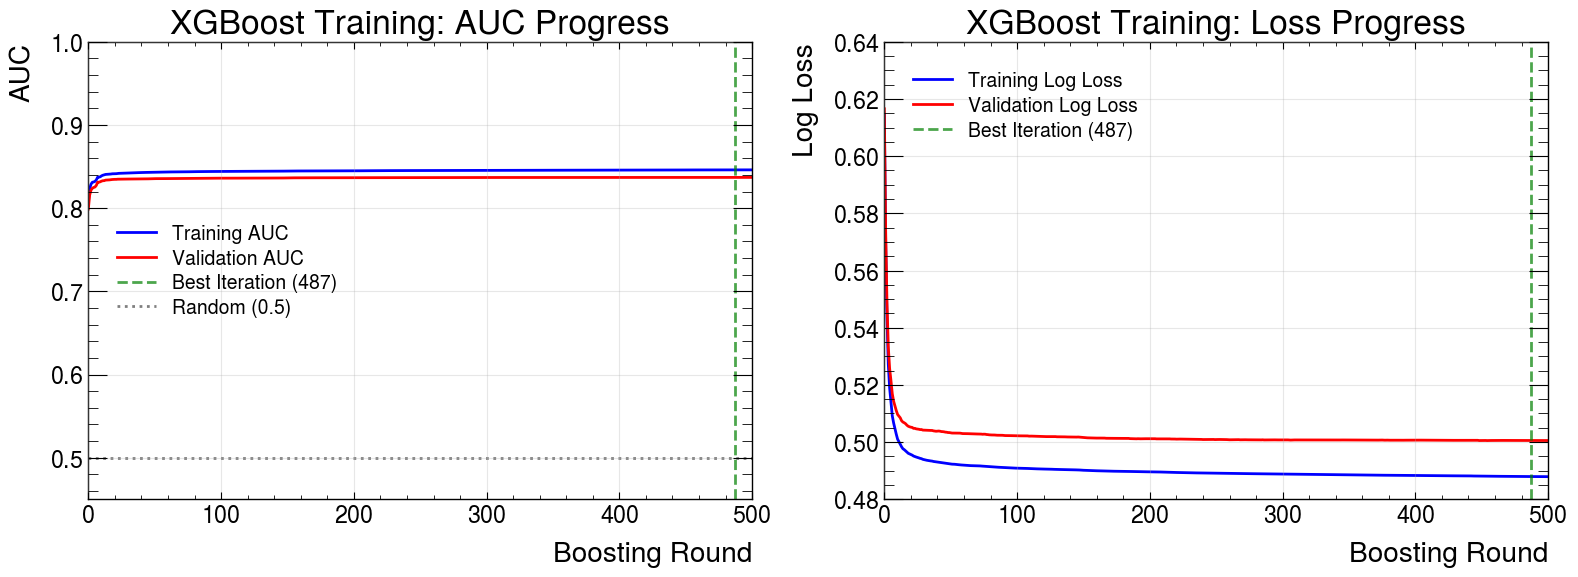

📊 Training summary:
   Final training AUC: 0.846051
   Best validation AUC: 0.500513
   Optimal stopping at round: 487
   Overfitting gap: 0.3455 (High)


In [11]:
# Plot training progress
print("📈 Visualizing training progress...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot AUC progression
axes[0].plot(evals_result['train']['auc'], label='Training AUC', color='blue', linewidth=2)
axes[0].plot(evals_result['validation']['auc'], label='Validation AUC', color='red', linewidth=2)
axes[0].axvline(x=model.best_iteration, color='green', linestyle='--', alpha=0.7, 
                label=f'Best Iteration ({model.best_iteration})')
axes[0].axhline(y=0.5, color='black', linestyle=':', alpha=0.5, label='Random (0.5)')
axes[0].set_xlabel('Boosting Round')
axes[0].set_ylabel('AUC')
axes[0].set_title('XGBoost Training: AUC Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0.45, 1.0)

# Plot Log Loss progression
axes[1].plot(evals_result['train']['logloss'], label='Training Log Loss', color='blue', linewidth=2)
axes[1].plot(evals_result['validation']['logloss'], label='Validation Log Loss', color='red', linewidth=2)
axes[1].axvline(x=model.best_iteration, color='green', linestyle='--', alpha=0.7, 
                label=f'Best Iteration ({model.best_iteration})')
axes[1].set_xlabel('Boosting Round')
axes[1].set_ylabel('Log Loss')
axes[1].set_title('XGBoost Training: Loss Progress')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FilePath+'Plots/XGBoost/XGB_qq_AUC_loss.png')
plt.show()

print(f"📊 Training summary:")
print(f"   Final training AUC: {evals_result['train']['auc'][-1]:.6f}")
print(f"   Best validation AUC: {model.best_score:.6f}")
print(f"   Optimal stopping at round: {model.best_iteration}")
overfitting = evals_result['train']['auc'][-1] - model.best_score
print(f"   Overfitting gap: {overfitting:.4f} ({'Low' if overfitting < 0.02 else 'Moderate' if overfitting < 0.05 else 'High'})")

## Model Evaluation on Test Set

In [12]:
# Evaluate model on test set
print("📊 EVALUATING MODEL ON TEST SET")
print("="*50)

# Make predictions
test_predictions_proba = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
test_predictions = (test_predictions_proba > 0.5).astype(int)

# Calculate comprehensive metrics
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, test_predictions_proba)
test_auc = auc(fpr, tpr)

print(f"🎯 TEST SET PERFORMANCE:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy:.1%})")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1 Score:  {f1:.4f}")
print(f"   ROC AUC:   {test_auc:.6f}")

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
print(f"\n📊 CONFUSION MATRIX:")
print(f"                Predicted")
print(f"Actual      Signal  Background")
print(f"Signal      {cm[0,0]:6d}    {cm[0,1]:6d}")
print(f"Background  {cm[1,0]:6d}    {cm[1,1]:6d}")

# Calculate detailed rates
TP, FP, FN, TN = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity
TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  # False Negative Rate

print(f"\n📊 DETAILED CLASSIFICATION RATES:")
print(f"   True Positive Rate (Sensitivity):  {TPR:.4f}")
print(f"   True Negative Rate (Specificity):  {TNR:.4f}")
print(f"   False Positive Rate:               {FPR:.4f}")
print(f"   False Negative Rate:               {FNR:.4f}")

# Performance validation
generalization_gap = abs(model.best_score - test_auc)
print(f"\n🔍 MODEL VALIDATION:")
print(f"   Validation AUC: {model.best_score:.6f}")
print(f"   Test AUC:       {test_auc:.6f}")
print(f"   Generalization gap: {generalization_gap:.4f} ({'Excellent' if generalization_gap < 0.01 else 'Good' if generalization_gap < 0.02 else 'Moderate'})")

📊 EVALUATING MODEL ON TEST SET
🎯 TEST SET PERFORMANCE:
   Accuracy:  0.7579 (75.8%)
   Precision: 0.8872
   Recall:    0.7557
   F1 Score:  0.8162
   ROC AUC:   0.838289

📊 CONFUSION MATRIX:
                Predicted
Actual      Signal  Background
Signal        5028      1558
Background    3963     12259

📊 DETAILED CLASSIFICATION RATES:
   True Positive Rate (Sensitivity):  0.7557
   True Negative Rate (Specificity):  0.7634
   False Positive Rate:               0.2366
   False Negative Rate:               0.2443

🔍 MODEL VALIDATION:
   Validation AUC: 0.500513
   Test AUC:       0.838289
   Generalization gap: 0.3378 (Moderate)


## Comprehensive Results Visualization

📈 Creating comprehensive results visualization...


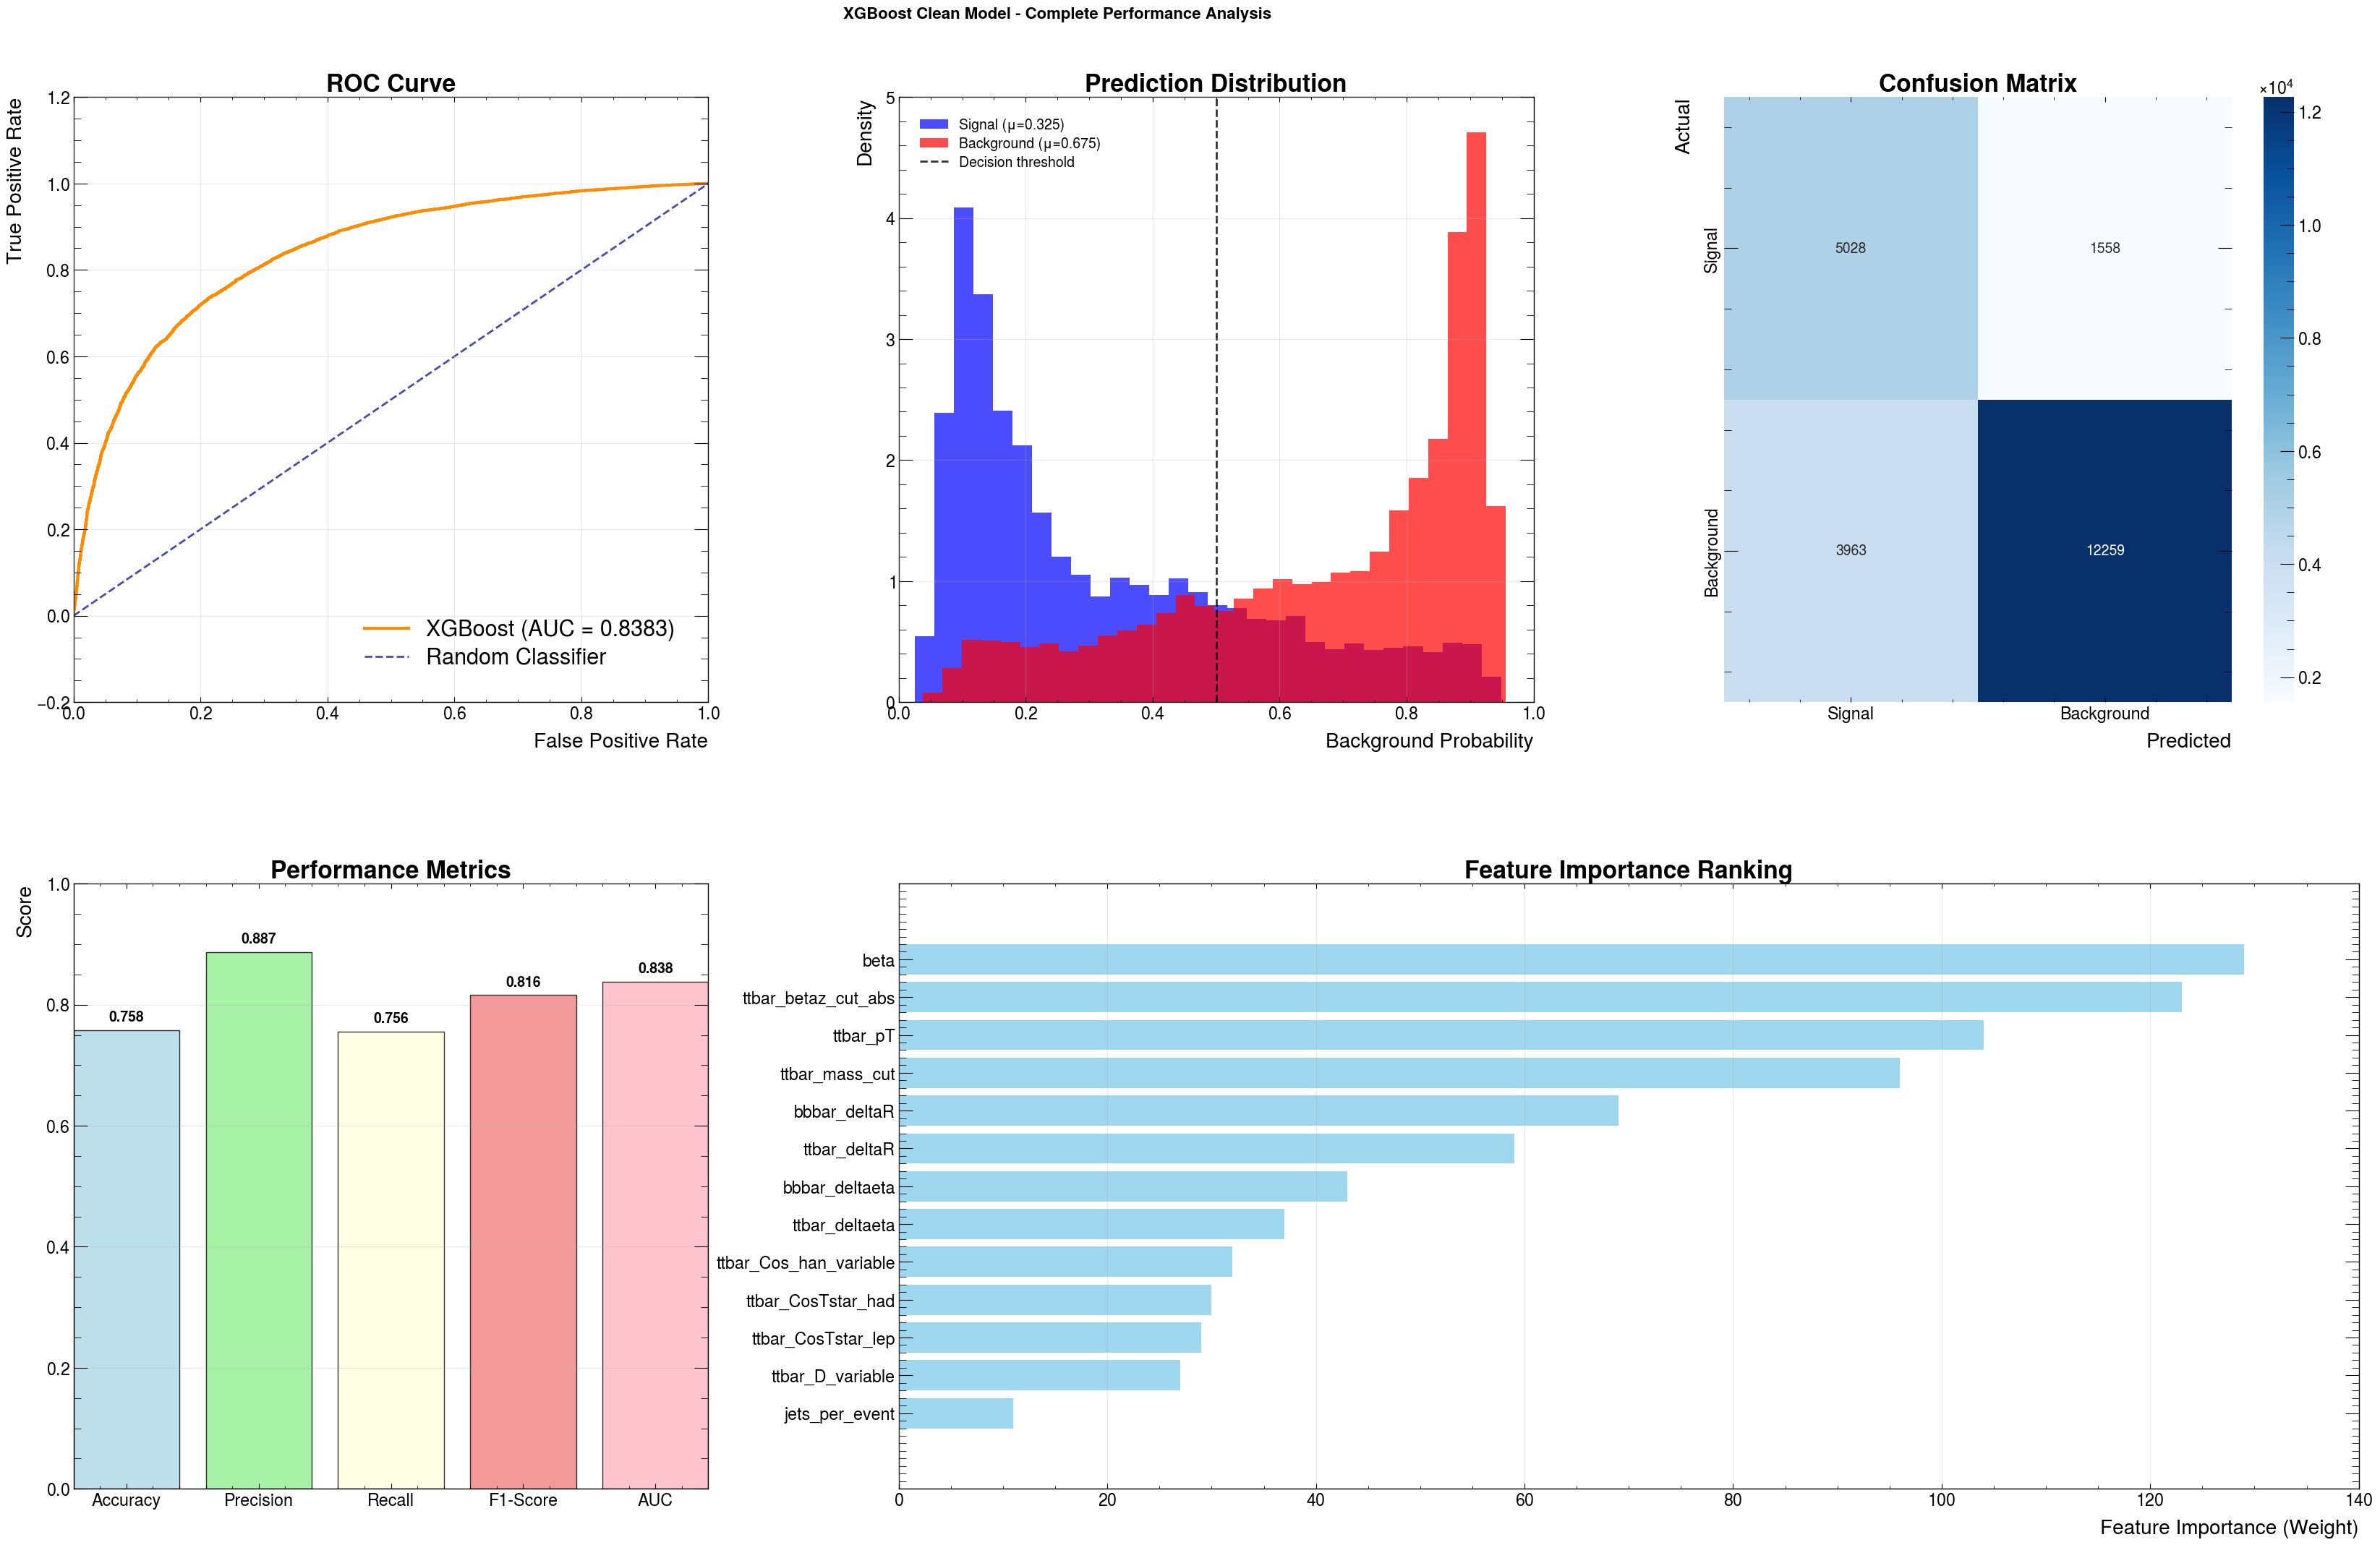

✅ Comprehensive analysis completed!
🎯 Final model achieves 83.8% AUC - Ready for physics analysis!


In [13]:
# Create comprehensive visualization of results
print("📈 Creating comprehensive results visualization...")

fig = plt.figure(figsize=(40, 25))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. ROC Curve
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(fpr, tpr, color='darkorange', lw=3, label=f'XGBoost (AUC = {test_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.7, label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontweight='bold')
ax1.legend(fontsize=22,loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Prediction Distribution
ax2 = fig.add_subplot(gs[0, 1])
signal_proba = test_predictions_proba[y_test == 0]
background_proba = test_predictions_proba[y_test == 1]

ax2.hist(signal_proba, bins=30, alpha=0.7, color='blue', 
         label=f'Signal (μ={signal_proba.mean():.3f})', density=True)
ax2.hist(background_proba, bins=30, alpha=0.7, color='red', 
         label=f'Background (μ={background_proba.mean():.3f})', density=True)
ax2.axvline(0.5, color='black', linestyle='--', alpha=0.8, label='Decision threshold')
ax2.set_title('Prediction Distribution', fontweight='bold')
ax2.set_xlabel('Background Probability')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
ax3 = fig.add_subplot(gs[0, 2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
            xticklabels=['Signal', 'Background'], yticklabels=['Signal', 'Background'])
ax3.set_title('Confusion Matrix', fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Performance Metrics Bar Chart
ax4 = fig.add_subplot(gs[1, 0])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [accuracy, precision, recall, f1, test_auc]
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink']

bars = ax4.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
ax4.set_ylim(0, 1)
ax4.set_title('Performance Metrics', fontweight='bold')
ax4.set_ylabel('Score')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. Feature Importance
ax5 = fig.add_subplot(gs[1, 1:])
feature_importance = model.get_score(importance_type='weight')
if feature_importance:
    importance_df = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'importance'])
    importance_df = importance_df.sort_values('importance', ascending=True)
    
    ax5.barh(range(len(importance_df)), importance_df['importance'], color='skyblue', alpha=0.8)
    ax5.set_yticks(range(len(importance_df)))
    ax5.set_yticklabels(importance_df['feature'])
    ax5.set_xlabel('Feature Importance (Weight)')
    ax5.set_title('Feature Importance Ranking', fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='x')

plt.suptitle('XGBoost Clean Model - Complete Performance Analysis', fontsize=16, fontweight='bold')
plt.savefig(FilePath+'Plots/XGBoost/XGB_qq_results.png')
plt.show()

print(f"✅ Comprehensive analysis completed!")
print(f"🎯 Final model achieves {test_auc:.1%} AUC - Ready for physics analysis!")